#DnCNN

##Download dataset

In [1]:
!gdown https://drive.google.com/uc?id=1qxQL3Dhw8-q4Emmb6bT8T2LkZ0jheoMu

Downloading...
From: https://drive.google.com/uc?id=1qxQL3Dhw8-q4Emmb6bT8T2LkZ0jheoMu
To: /content/dblocking-dataset.zip
67.5MB [00:01, 36.1MB/s]


In [0]:
local_zip = 'dblocking-dataset.zip'

import zipfile
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(local_zip[:-4])
zip_ref.close()

##Visualize JPEG compression

In [0]:
# Perform JPEG compression
import io
from PIL import Image
def compress_image(img, quality = 10, display_image = False):
    """ Perform JPEG compression
    @params:
    img : PIL object
    quality :  Quality values must be in the range [0, 100]. Small quality values result in more compression and stronger compression artifacts.
    
    Returns:
    PIL compressed image object
    """
    buffer = io.BytesIO() #using a buffer in case we do not wish to save it in memory
    img.save(buffer, "JPEG", quality=quality)
    buffer.seek(0)
    compressed_image = Image.open(io.BytesIO(buffer.read()))
    
    if display_image == True:
        print("compressed image")
        display(compressed_image)
        
    return compressed_image

compressed image


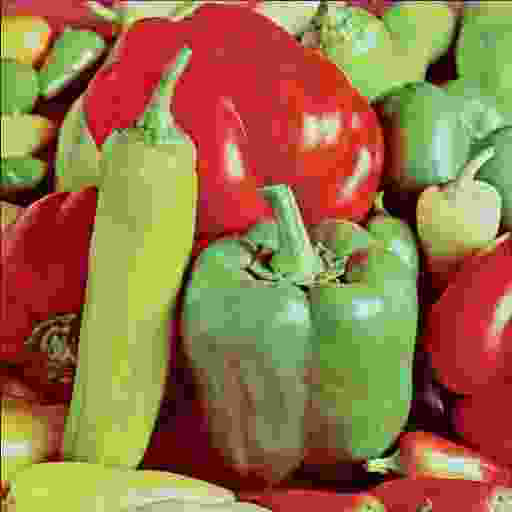

In [4]:
img_path = '/content/dblocking-dataset/validation/set14-downgraded/pepper.png'
img = Image.open(img_path)
compressed_image = compress_image(img, quality = 5, display_image = True)

##Generate dataset

In [0]:
'''Workflow:
 
 1. For each image in the provided train folder, patches are cut out of the image (patch size -> 50*50 with stride of 10)
 2. Each patch is randomly rotated and compressed into quality in range of [5,10,50,90,100]
 3. The compressed patch is subtracted from the original patch to get the artifact data (residual data)
 4. The compressed patch becomes the i/p to the network and the artifact is learnt by the model (o/p)
 5. Once the model is trained a compressed image is given to the network and the artifact produced by the network is subtracted from the compressed image 
 and SSIM score is calculated b/w original clean image and compressed image  and b/w original clean image and output image
 '''

In [0]:
# https://github.com/husqin/DnCNN-keras/blob/master/data.py
import glob
import os
import cv2
import numpy as np
from multiprocessing import Pool

aug_times = 1

def data_aug(img, mode=0):
    """Data augmentation
    
    Notes:
    1. The flipud() function is used to flip an given array in the up/down direction.
    2. np.rot90 -> k : Number of times the array is rotated by 90 degrees.
    """
    
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))
    
def gen_patches(file_name):
    """ Patches are cropped out of the i/p image 
    after scaling it into 4 versions([1, 0.9, 0.8, 0.7])
    
    Data augmentation is performed along with it
    """
    # read image
    img = cv2.imread(file_name, 0)  # gray scale
    img = cv2.resize(img, (250,250), interpolation=cv2.INTER_CUBIC)
    
    h, w = img.shape
    scales = [1, 0.9, 0.8, 0.7]
    patches = []

    for s in scales:
        h_scaled, w_scaled = int(h*s),int(w*s)
        img_scaled = cv2.resize(img, (h_scaled,w_scaled), interpolation=cv2.INTER_CUBIC)
        # extract patches
        for i in range(0, h_scaled-patch_size+1, stride):
            for j in range(0, w_scaled-patch_size+1, stride):
                x = img_scaled[i:i+patch_size, j:j+patch_size]
                # data aug
                for k in range(0, aug_times):
                    x_aug = data_aug(x, mode=np.random.randint(0,8))
                    patches.append(x_aug)
    
    return patches

In [6]:
file_list = glob.glob('/content/dblocking-dataset/train/*/*.bmp')[:176] # Train data
print("{} images found in train folder".format(len(file_list)))


save_dir = '/content/train/npy_data/'

num_threads = 16    

# initialize
res = []
patch_size, stride = 50, 10 #patch size is 50*50

# generate patches
for i in range(0,len(file_list),num_threads):
    # use multi-process to speed up
    p = Pool(num_threads)
    patch = p.map(gen_patches,file_list[i:min(i+num_threads,len(file_list))])
    for x in patch:
        res += x

    print('Images '+str(i)+' to '+str(i+num_threads)+' processed...')

    
    
# save to .npy
res = np.array(res)
print('Shape of result = ' + str(res.shape))
print('Saving data...')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(save_dir+'clean_patches.npy', res)


176 images found in train folder
Images 0 to 16 processed...
Images 16 to 32 processed...
Images 32 to 48 processed...
Images 48 to 64 processed...
Images 64 to 80 processed...
Images 80 to 96 processed...
Images 96 to 112 processed...
Images 112 to 128 processed...
Images 128 to 144 processed...
Images 144 to 160 processed...
Images 160 to 176 processed...
Shape of result = (209440, 50, 50)
Saving data...


##Create compressed patches

In [0]:
train_data_clean = "/content/train/npy_data/clean_patches.npy"
data = np.load(train_data_clean)

In [0]:
import random

c_data = [] #np.zeros(data.shape)
for idx, img in enumerate(data[:]):
#     print(img.shape)
    print(idx)
    img = Image.fromarray(img)
    
    q = random.choice([5,10,50,90,100])
    c_img = compress_image(img, quality = q, display_image = False) #compressed image
    c_img = np.array(c_img)
    c_data.append(c_img)
    

In [0]:
save_dir = '/content/train/npy_data/'

In [10]:
c_data = np.array(c_data)
print('Shape of result = ' + str(c_data.shape))
print('Saving data...')
if not os.path.exists(save_dir):
    os.makedir(save_dir)
np.save(save_dir+'compressed_patches.npy', c_data)

Shape of result = (209440, 50, 50)
Saving data...


##Data generator

In [0]:
import numpy as np

In [12]:
train_data_clean = "/content/train/npy_data/clean_patches.npy"
data = np.load(train_data_clean)
print('Size of train data: ({}, {}, {})'.format(data.shape[0],data.shape[1],data.shape[2]))

Size of train data: (209440, 50, 50)


In [0]:
data = data.reshape((data.shape[0],data.shape[1],data.shape[2],1))
data = data.astype('float32')/255.0

In [14]:
train_data_compressed = "/content/train/npy_data/compressed_patches.npy"
c_data = np.load(train_data_compressed)
print('Size of train data: ({}, {}, {})'.format(data.shape[0],data.shape[1],data.shape[2]))

Size of train data: (209440, 50, 50)


In [0]:
c_data = c_data.reshape((data.shape[0],data.shape[1],data.shape[2],1))
c_data = c_data.astype('float32')/255.0

In [0]:
def train_datagen(y_, c_data, batch_size=8):
    """
    Generator to yield data to the network
    
    @params:
    y_ : tensor of clean patches
    c_data  tensor of compressed patches
    
    Returns:
    ge_batch_x, artifacts : i/p, o/p for the network
    """

    indices = list(range(y_.shape[0]))
    while(True):
        np.random.shuffle(indices)    # shuffle
        
        for i in range(0, int(len(indices)), batch_size):
            ge_batch_y = y_[indices[i:i+batch_size]] #clean images batch
            artifacts = c_data[indices[i:i+batch_size]] - y_[indices[i:i+batch_size]] #subtract the grayscale images to get the artifacts batch

            ge_batch_x = ge_batch_y + artifacts  # input image = clean image + artifacts
            yield ge_batch_x, artifacts

##Model

In [18]:
from keras.models import *
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract

Using TensorFlow backend.


In [19]:
# confirm channel order
from keras import backend as K
print(K.image_data_format())

channels_last


In [0]:
def DnCNN():
    
    inpt = Input(shape=(None,None,1))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = Activation('relu')(x)
    # 15 layers, Conv+BN+relu
    for i in range(15):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
#         x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)   
    # last layer, Conv
    x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([inpt, x])   # input - artifacts
    model = Model(inputs=inpt, outputs=x)
    
    return model

In [21]:
model = DnCNN()

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       activation_1[0][0]               
____________________________________________________________________________________________

##Train

In [0]:
batch_size = 128
lr = 0.001
save_every = 10 #save model h5 after every "n" epochs
epoch = 10

In [0]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [0]:
save_dir = '/content/train/'

In [0]:
def step_decay(epoch,lr):
    """
    Learning rate scheduler, decrease learning rate by 10 after 50 eopchs
    
    @params:
    epoch : Num of epochs 
    lr : Learning rate
    
    Returns:
    lr : Learning rate (callback)
    """
    
    initial_lr = lr
    if epoch<50:
        lr = initial_lr
    else:
        lr = initial_lr/10

    return lr

In [28]:
# compile the model
model.compile(optimizer=Adam(), loss=['mse'])

# use call back functions
ckpt = ModelCheckpoint(save_dir+'/model_{epoch:02d}.h5', monitor='val_loss', 
                verbose=0, period=save_every)

lr = LearningRateScheduler(step_decay)

# train 
history = model.fit_generator(train_datagen(data, c_data, batch_size=batch_size),
                steps_per_epoch=int(len(data)/10)//batch_size, epochs=epoch, verbose=1, 
                callbacks=[ckpt, lr]) #decreased the num of steps to reduce training time by dividng by 10




Epoch 1/10
163/163 [==============================] - 99s 605ms/step - loss: 0.0153
Epoch 2/10
163/163 [==============================] - 92s 565ms/step - loss: 0.0022
Epoch 3/10
163/163 [==============================] - 92s 563ms/step - loss: 0.0952
Epoch 4/10
163/163 [==============================] - 91s 558ms/step - loss: 0.0091
Epoch 5/10
163/163 [==============================] - 91s 559ms/step - loss: 0.0030
Epoch 6/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0020
Epoch 7/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0018
Epoch 8/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0017
Epoch 9/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0016
Epoch 10/10
163/163 [==============================] - 91s 559ms/step - loss: 0.0016


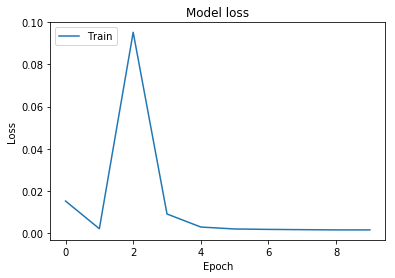

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Test

In [0]:
# Load model
import os
from keras.models import load_model
source_dir = "/content/train"
model_name = "model_10"
model = load_model(os.path.join(source_dir,model_name+".h5"))
print("Loaded model from disk",model_name)








Loaded model from disk model_10


19 images found in test folder
0 /content/dblocking-dataset/validation/Set5/woman.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


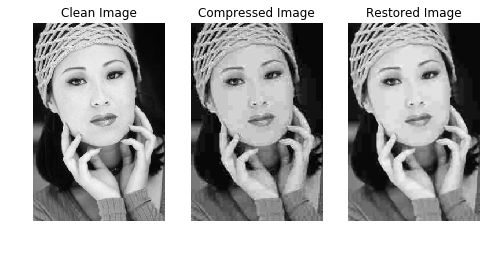

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9154723190116828 0.9349656344433985
psnr_clean_vs_test, psnr_clean_vs_predicted -> 28.438126696590107 29.308165185800977
********************************************************************************
1 /content/dblocking-dataset/validation/Set5/bird.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


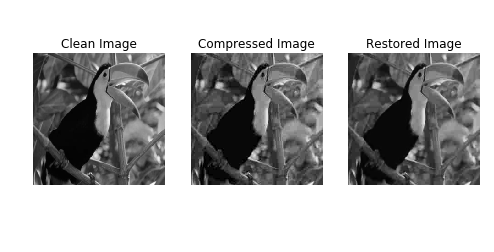

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9163144883299303 0.9380876565281127
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.372908223488192 31.403143014404044
********************************************************************************
2 /content/dblocking-dataset/validation/Set5/butterfly.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


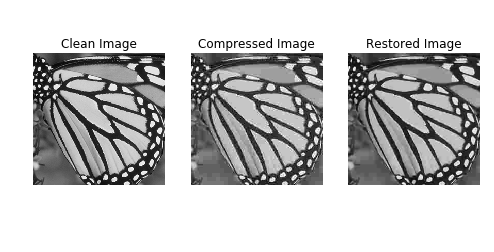

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8979807914649492 0.9307759791027459
psnr_clean_vs_test, psnr_clean_vs_predicted -> 25.24429691813417 26.85700523250468
********************************************************************************
3 /content/dblocking-dataset/validation/Set5/baby.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


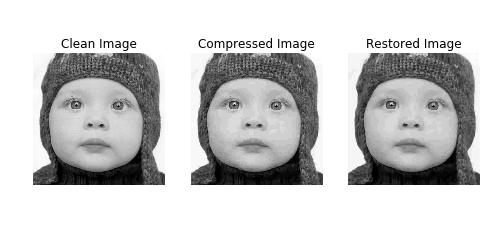

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9170561223606173 0.9305306120730354
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.892128797180685 30.881089641307554
********************************************************************************
4 /content/dblocking-dataset/validation/Set5/head.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


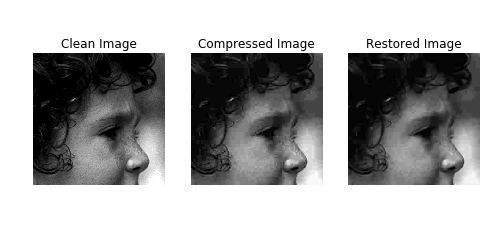

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.854856308720513 0.8680751712827623
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.006942299589316 30.3308537964135
********************************************************************************
5 /content/dblocking-dataset/validation/Set14/coastguard.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


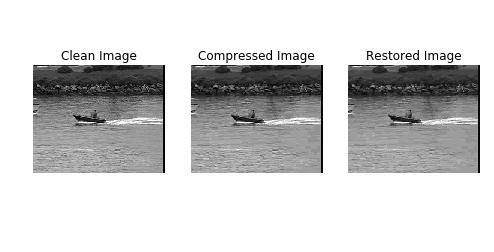

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8445582546686997 0.8501954869184766
psnr_clean_vs_test, psnr_clean_vs_predicted -> 27.455524493258963 27.742644116051203
********************************************************************************
6 /content/dblocking-dataset/validation/Set14/foreman.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


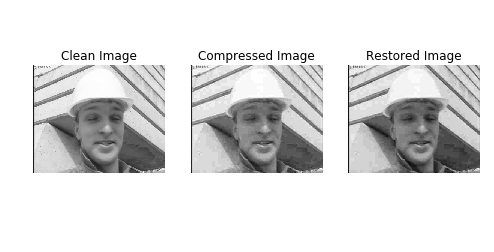

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.920225037765183 0.9401501951689846
psnr_clean_vs_test, psnr_clean_vs_predicted -> 29.554196683726204 29.466165378932565
********************************************************************************
7 /content/dblocking-dataset/validation/Set14/bridge.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


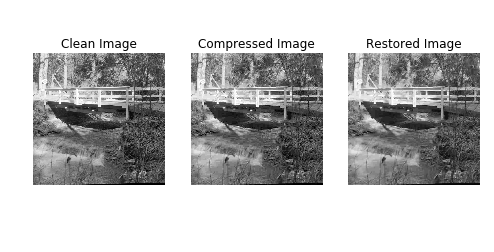

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8127904384048816 0.8229415785916618
psnr_clean_vs_test, psnr_clean_vs_predicted -> 25.12703776848675 25.52133664036529
********************************************************************************
8 /content/dblocking-dataset/validation/Set14/pepper.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


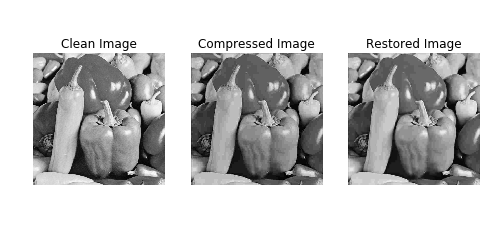

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9012280173343473 0.9201108778799167
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.14044664480258 30.729015621754158
********************************************************************************
9 /content/dblocking-dataset/validation/Set14/comic.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


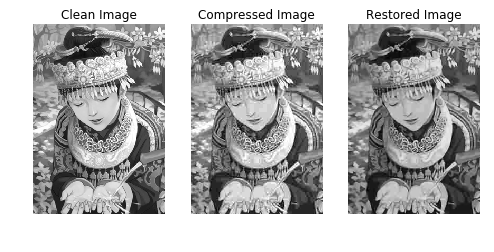

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8608576238365563 0.881562836139117
psnr_clean_vs_test, psnr_clean_vs_predicted -> 24.096936551439608 24.82375787269072
********************************************************************************
10 /content/dblocking-dataset/validation/Set14/face.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


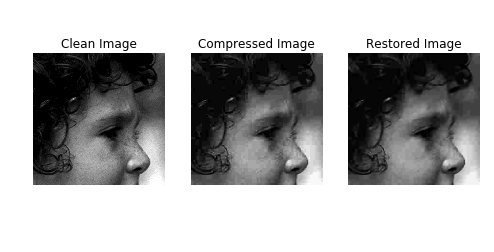

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8533467244189756 0.8676909571335562
psnr_clean_vs_test, psnr_clean_vs_predicted -> 29.960195339046347 30.332222603303048
********************************************************************************
11 /content/dblocking-dataset/validation/Set14/barbara.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


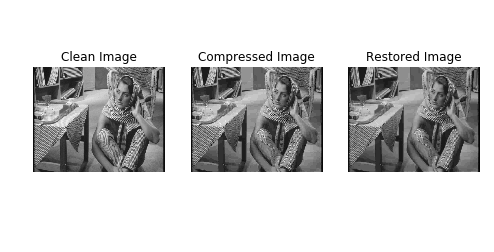

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8704153306380021 0.8839884960364149
psnr_clean_vs_test, psnr_clean_vs_predicted -> 26.461881638121113 27.011821655781784
********************************************************************************
12 /content/dblocking-dataset/validation/Set14/ppt3.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


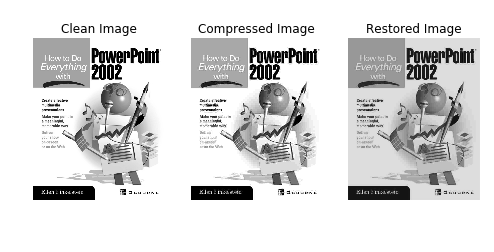

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9448206567280331 0.9574470682543238
psnr_clean_vs_test, psnr_clean_vs_predicted -> 28.32450267925049 28.39816254591139
********************************************************************************
13 /content/dblocking-dataset/validation/Set14/zebra.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


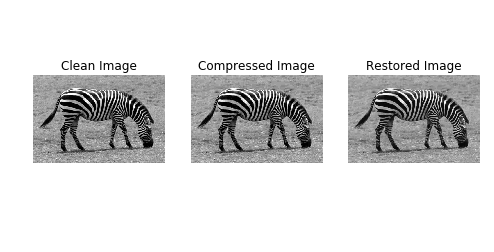

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8755632857717385 0.8908281886507937
psnr_clean_vs_test, psnr_clean_vs_predicted -> 27.386458176172606 28.057729560520816
********************************************************************************
14 /content/dblocking-dataset/validation/Set14/lenna.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


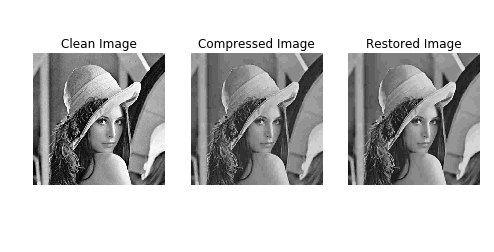

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9038991641189665 0.9189123943151591
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.025454979584005 30.522513735389435
********************************************************************************
15 /content/dblocking-dataset/validation/Set14/man.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


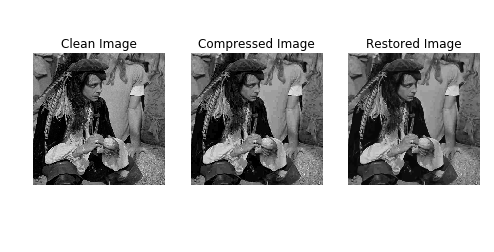

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8408084653461125 0.8567411564386678
psnr_clean_vs_test, psnr_clean_vs_predicted -> 26.482321117502757 27.078299901665428
********************************************************************************
16 /content/dblocking-dataset/validation/Set14/flowers.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


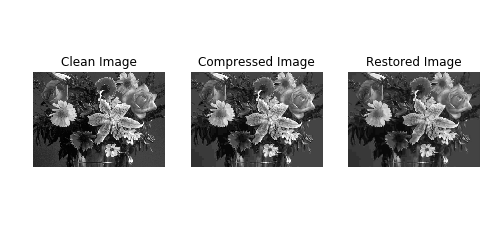

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8778813846584103 0.8962494041916848
psnr_clean_vs_test, psnr_clean_vs_predicted -> 27.19250795553028 28.020199950741997
********************************************************************************
17 /content/dblocking-dataset/validation/Set14/monarch.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


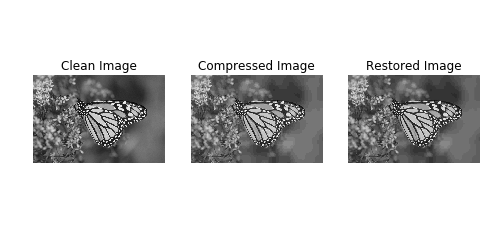

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9347164020348735 0.9530066510755668
psnr_clean_vs_test, psnr_clean_vs_predicted -> 29.475220034414953 30.69275202512845
********************************************************************************
18 /content/dblocking-dataset/validation/Set14/baboon.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


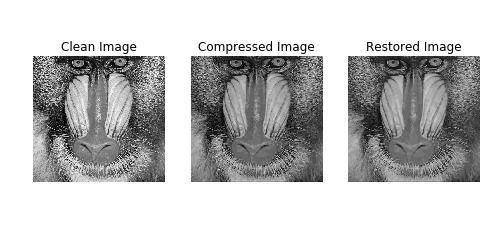

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.7701083275271818 0.7748798565078083
psnr_clean_vs_test, psnr_clean_vs_predicted -> 23.206353362782938 23.529630385883916
********************************************************************************
Average PSNR = 28.46, SSIM = 0.90


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr, compare_ssim
from google.colab.patches import cv2_imshow
import cv2
import glob
from PIL import Image

psnr = []
ssim = []

file_list = glob.glob('/content/dblocking-dataset/validation/[!set]*/*.png')
print("{} images found in test folder".format(len(file_list)))

for idx, file in enumerate(file_list[:]):
    print(idx, file)
    print("+"*100)

    fig=plt.figure(figsize=(8, 4))
    plt.gca().axis('off')
#     plt.gca().set_title('Redsidual DnCNN in Action')

    clean_img = Image.open(file).convert("L")
    fig.add_subplot(1, 3, 1)   # subplot one
    plt.gca().set_title('Clean Image')
    plt.gca().axis('off')
    plt.imshow(clean_img, cmap=plt.cm.gray)

    # compress the image
    compressed_img = compress_image(clean_img, quality = 10, display_image = False) #compressed image
    fig.add_subplot(1, 3, 2)   # subplot two
    plt.gca().set_title('Compressed Image')
    plt.gca().axis('off')
    plt.imshow(compressed_img, cmap=plt.cm.gray)


    # convert PIL objects (clean image and compressed image) to numpy arrays and pre-process them
    clean_img = np.array(clean_img, dtype='float32') / 255.0

    compressed_img = np.array(compressed_img, dtype='float32') / 255.0

    # test image will be the compressed image
    img_test = compressed_img 

    # predict the residual image
    img_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 1) 
    residual_image = model.predict(img_test)

    residual_image = residual_image.reshape((compressed_img.shape[0], compressed_img.shape[1]))

    # subtract the residual image from the compressed image
    restored_image = compressed_img - residual_image
    fig.add_subplot(1, 3, 3)   # subplot two
    plt.gca().set_title('Restored Image')
    plt.gca().axis('off')
    plt.imshow(restored_image, cmap=plt.cm.gray)


    # calculate evaluation metrics
    # img_out = residual_image.reshape(img_clean.shape)
    # img_out = np.clip(img_out, 0, 1)
    psnr_clean_vs_test, psnr_clean_vs_predicted = compare_psnr(clean_img, compressed_img), compare_psnr(clean_img, restored_image)
    ssim_clean_vs_test, ssim_clean_vs_predicted = compare_ssim(clean_img, compressed_img), compare_ssim(clean_img, restored_image)
    psnr.append(psnr_clean_vs_predicted)
    ssim.append(ssim_clean_vs_predicted)
    
    plt.show()

    print("*"*80)
    print("Evaluation Metrics")
    print("ssim_clean_vs_test, ssim_clean_vs_predicted ->",ssim_clean_vs_test, ssim_clean_vs_predicted)
    print("psnr_clean_vs_test, psnr_clean_vs_predicted ->",psnr_clean_vs_test, psnr_clean_vs_predicted)
    print("*"*80)

psnr_avg = sum(psnr)/len(psnr)
ssim_avg = sum(ssim)/len(ssim)

print('Average PSNR = {0:.2f}, SSIM = {1:.2f}'.format(psnr_avg, ssim_avg))

##Prediction on a single image

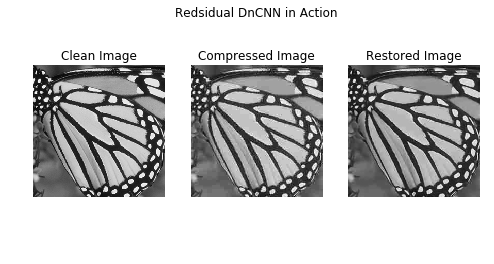

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9230674598917905 0.9460206493777278
psnr_clean_vs_test, psnr_clean_vs_predicted -> 26.632442191066406 28.051921301367685
********************************************************************************


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr, compare_ssim
from google.colab.patches import cv2_imshow
import cv2


fig=plt.figure(figsize=(8, 4))
plt.gca().axis('off')
plt.gca().set_title('Redsidual DnCNN in Action')

# test image
file = '/content/dblocking-dataset/validation/Set5/butterfly.png'

clean_img = Image.open(file).convert("L")
fig.add_subplot(1, 3, 1)   # subplot one
plt.gca().set_title('Clean Image')
plt.gca().axis('off')
plt.imshow(clean_img, cmap=plt.cm.gray)

# compress the image
compressed_img = compress_image(clean_img, quality = 15, display_image = False) #compressed image
fig.add_subplot(1, 3, 2)   # subplot two
plt.gca().set_title('Compressed Image')
plt.gca().axis('off')
plt.imshow(compressed_img, cmap=plt.cm.gray)


# convert PIL objects (clean image and compressed image) to numpy arrays and pre-process them
clean_img = np.array(clean_img, dtype='float32') / 255.0

compressed_img = np.array(compressed_img, dtype='float32') / 255.0

# test image will be the compressed image
img_test = compressed_img 

# predict the residual image
img_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 1) 
residual_image = model.predict(img_test)

residual_image = residual_image.reshape((compressed_img.shape[0], compressed_img.shape[1]))

# subtract the residual image from the compressed image
restored_image = compressed_img - residual_image
fig.add_subplot(1, 3, 3)   # subplot two
plt.gca().set_title('Restored Image')
plt.gca().axis('off')
plt.imshow(restored_image, cmap=plt.cm.gray)


# calculate evaluation metrics
# img_out = residual_image.reshape(img_clean.shape)
# img_out = np.clip(img_out, 0, 1)
psnr_clean_vs_test, psnr_clean_vs_predicted = compare_psnr(clean_img, compressed_img), compare_psnr(clean_img, restored_image)
ssim_clean_vs_test, ssim_clean_vs_predicted = compare_ssim(clean_img, compressed_img), compare_ssim(clean_img, restored_image)

plt.show()

print("*"*80)
print("Evaluation Metrics")
print("ssim_clean_vs_test, ssim_clean_vs_predicted ->",ssim_clean_vs_test, ssim_clean_vs_predicted)
print("psnr_clean_vs_test, psnr_clean_vs_predicted ->",psnr_clean_vs_test, psnr_clean_vs_predicted)
print("*"*80)




**ssim_clean_vs_predicted(predicted) is greater than ssim_clean_vs_test(compressed)**

**Hence we have acheived the goal of removing artifacts**

##Difference b/w compressed and clean image

Our goal was to find the residual image as shown in Figure 3

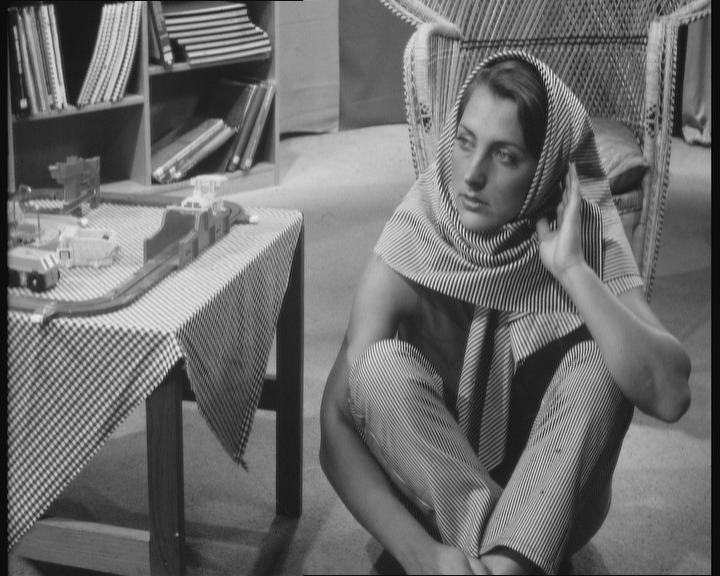

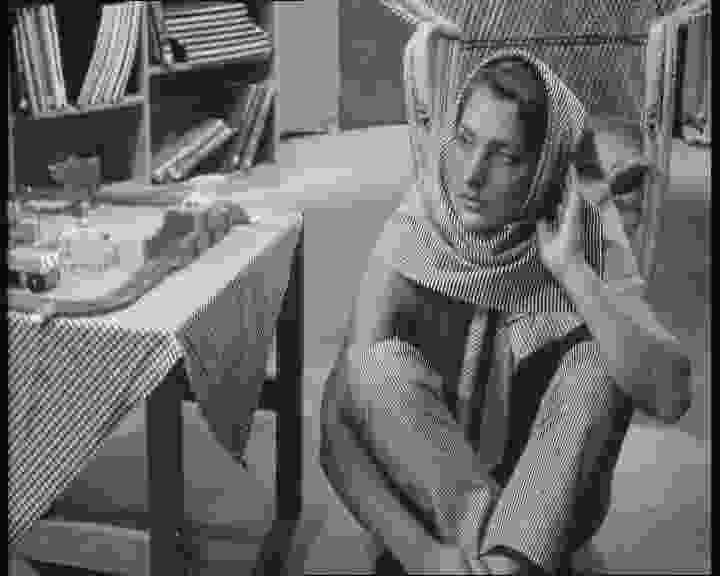

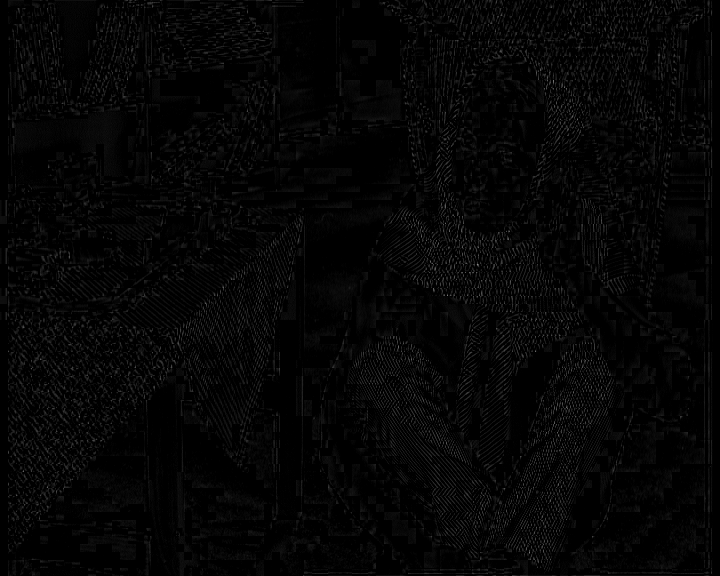

In [0]:
file = '/content/dblocking-dataset/validation/Set14/barbara.png'

img_clean = Image.open(file).convert("L")
display(img_clean)
# img_clean= Image.fromarray(img_clean)

c_img = compress_image(img_clean, quality = 5, display_image = False) #compressed image
display(c_img)

from PIL import ImageChops

diff = ImageChops.subtract(c_img, img_clean)
display(diff)